In [ ]:
! sbatch_tail -p gpu -q gpu --gres=gpu:A100:4 --cpus-per-task 20 --mem-per-gpu 80G --ntasks-per-node=4 slurm/submit.sh "predict --config config/base_v3.yml --scprint_training.noise [0.7,1.0] --scprint_training.mask_ratio [] --model.dropout 0 --data.num_workers 17 --data.force_recompute_indices True --data.weight_scaler 0 --data.test_split 0 --data.batch_size 120 --trainer.num_nodes 1 --model.expr_emb_style metacell --data.get_knn_cells True --data.metacell_mode 0 --model.expr_encoder_layers 1 --model.compress_class_dim \"{'cell_type_ontology_term_id':64,'tissue_ontology_term_id':32,'disease_ontology_term_id':32,'age_group':8,'assay_ontology_term_id':12,'self_reported_ethnicity_ontology_term_id':8,'sex_ontology_term_id':2,'organism_ontology_term_id':8,'cell_culture':2}\" --model.layers_cls [256] --ckpt_path /pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_v2/czg34ita/checkpoints/last.ckpt"

In [ ]:
sbatch_tail -p gpu -q gpu --gres=gpu:1 --cpus-per-task 10 --mem-per-gpu 90G --ntasks-per-node=1 slurm/submit.sh "predict --config config/base_v3.yml --model.dropout 0 --data.num_workers 9 --data.weight_scaler 0 --data.test_split 0 --data.batch_size 60 --trainer.num_nodes 1 --trainer.logger null --model.pred_embedding ['all'] --ckpt_path ../models/ji9krimq.ckpt"

## modified the model to replace logging of an anndata to logging of dataframe parquets


In [1]:
# set this
self.keep_all_labels_pred = True

NameError: name 'self' is not defined

In [ ]:
# know this:
model.classes
model.hparams["classes"](counts)
num = {
    "cell_type_ontology_term_id": 3,
    "tissue_ontology_term_id": 3,
    "disease_ontology_term_id": 3,
    "age_group": 3,
    "assay_ontology_term_id": 3,
    "self_reported_ethnicity_ontology_term_id": 3,
    "sex_ontology_term_id": 1,
    "organism_ontology_term_id": 3,
    "cell_culture": 1,
}

In [ ]:
def log_adata(self, gtclass=None, name=""):
    """
    log_adata will log an adata from predictions.
    It will log to tensorboard and wandb if available

    see @utils.log_adata
    """
    try:
        mdir = self.logger.save_dir if self.logger.save_dir is not None else "/tmp"
    except:
        mdir = "data/"
    if not os.path.exists(mdir):
        os.makedirs(mdir)
    self.embs = (
        torch.concat([v for k, v in self.embs.items()], dim=1)
        .cpu()
        .numpy()
        .astype(np.float16)
    )

    count = {
        "cell_type_ontology_term_id": 3,
        "tissue_ontology_term_id": 3,
        "disease_ontology_term_id": 3,
        "age_group": 3,
        "assay_ontology_term_id": 3,
        "self_reported_ethnicity_ontology_term_id": 3,
        "sex_ontology_term_id": 1,
        "organism_ontology_term_id": 3,
        "cell_culture": 1,
    }
    tot = 0
    locs = []
    predloc = []
    for val in self.classes:
        num = self.hparams["classes"][val]
        pred_slice = self.pred[:, tot : tot + num]
        loc = pred_slice.argsort(-1)[:, -count[val] :].flip([-1])
        top_k = torch.gather(pred_slice, 1, loc)
        predloc.append(top_k.cpu().numpy().astype(np.float16))
        locs.append(loc.cpu().numpy().astype(np.uint16))
        tot += num

    predloc = np.hstack(predloc)
    locs = np.hstack(locs)
    save = (
        str(mdir)
        + "/step_"
        + str(self.global_step)
        + "_"
        + str(self.name)
        + "_"
        + str(name)
        + "_"
        + str(self.global_rank)
    )
    np.save(save + "_top3.npz", locs)
    np.save(save + "_scores.npz", predloc)
    np.save(save + "_embs.npz", self.embs)

## run stuff


In [ ]:
! uv pip install umap-pytorch

Using Python 3.11.11 environment at: /pasteur/appa/homes/jkalfon/scPRINT/umap
Resolved 10 packages in 79ms                                         
░░░░░░░░░░░░░░░░░░░░ [0/8] Installing wheels...                                 warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 8 packages in 2.57s                               
 + joblib==1.5.2
 + llvmlite==0.45.1
 + numba==0.62.1
 + pynndescent==0.5.13
 + scikit-learn==1.7.2
 + threadpoolctl==3.6.0
 + tqdm==4.67.1
 + umap-learn==0.5.9.post2


In [2]:
import os
from umap_pytorch import load_pumap
from umap_pytorch import PUMAP

import json
from scdataloader.utils import translate
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%reload_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'scdataloader'

In [2]:
embs = []
scores = []
cl = []
LOC = "/pasteur/appa/scratch/jkalfon/45316476/"  # ".45050971./../"
for i in os.listdir(LOC):
    if i.startswith("step_0__predict_part_") and i.endswith("_embs.npz"):
        embs.append(np.load(LOC + i)["arr_0"])
    if i.startswith("step_0__predict_part_") and i.endswith("_scores.npz"):
        scores.append(np.load(LOC + i)["arr_0"])
    if i.startswith("step_0__predict_part_") and i.endswith("_top3.npz"):
        cl.append(np.load(LOC + i)["arr_0"])
embs = np.vstack(embs)
scores = np.vstack(scores)
cl = np.vstack(cl)
cl.shape

(20808320, 23)

In [ ]:
20808320/4

[autoreload of ipykernel.control failed: Traceback (most recent call last):
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 621, in superreload
    update_generic(old_obj, new_obj)
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 447, in update_generic
    update(a, b)
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 399, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 447, in update_generic
    update(a, b)
  File "/pasteur/appa/homes/jka

In [ ]:
"cell_type_ontology_term_id": 3,
"tissue_ontology_term_id": 3,
"disease_ontology_term_id": 3,
"age_group": 3,
"assay_ontology_term_id": 3,
"self_reported_ethnicity_ontology_term_id": 3,
"sex_ontology_term_id": 1,
"organism_ontology_term_id": 3,
"cell_culture": 3,

In [ ]:
256 + 64 + 32 + 32 + 8 + 12 + 8 + 2 + 8 + 2

array([[402, 175, 416, ...,   0,   1,   1],
       [402, 175, 416, ...,   0,   1,   1],
       [402, 175, 416, ...,   0,   1,   1],
       ...,
       [402, 175, 416, ...,   0,   1,   1],
       [402, 175, 416, ...,   0,   1,   1],
       [402, 416, 175, ...,   0,   1,   1]],
      shape=(20040, 22), dtype=uint16)

In [ ]:
the order of elements in the columns of the embeddings and classification parquet would be:
[
 'other',
 'cell_type_ontology_term_id',
 'tissue_ontology_term_id',
 'disease_ontology_term_id',
 'age_group',
 'assay_ontology_term_id',
 'self_reported_ethnicity_ontology_term_id',
 'sex_ontology_term_id',
 'organism_ontology_term_id',
 'cell_culture']

the embeddings columns are concatenation of each of these with their dimension being:
256 + 64 + 32 + 32 + 8 + 12 + 8 + 2 + 8 + 2

accessed like so: cell_emb = embs[:, 256 : 256 + 64]

the classification columns are concatenation of the top 3 predicted classes for each of these with their dimension being:
3 + 3 + 3 + 3 + 3 + 3 + 1 + 3 + 1
accessed like so: cell_labels = cl[:, 0:3]; cell_labels_score = score[:, 0:3] 



In [6]:
with open("/pasteur/appa/scratch/jkalfon/label_decoders.json", "r") as f:
    decoders = json.load(f)

In [ ]:
decoders["organism_ontology_term_id"]

{'0': 'NCBITaxon:10090',
 '1': 'NCBITaxon:10181',
 '2': 'NCBITaxon:3702',
 '3': 'NCBITaxon:4577',
 '4': 'NCBITaxon:6239',
 '5': 'NCBITaxon:7227',
 '6': 'NCBITaxon:7955',
 '7': 'NCBITaxon:9031',
 '8': 'NCBITaxon:9483',
 '9': 'NCBITaxon:9544',
 '10': 'NCBITaxon:9598',
 '11': 'NCBITaxon:9606',
 '12': 'NCBITaxon:9823',
 '13': 'NCBITaxon:9913',
 '14': 'NCBITaxon:9940',
 '15': 'NCBITaxon:9986'}

In [22]:
res = translate(
    set(decoders["self_reported_ethnicity_ontology_term_id"].values()),
    "self_reported_ethnicity_ontology_term_id",
)
res

{'HANCESTRO:0588': 'Jewish Israeli',
 'HANCESTRO:0383': 'Irish',
 'HANCESTRO:0485': 'Bangladeshi',
 'HANCESTRO:0018': 'uncategorised population',
 'HANCESTRO:0439': 'Iraqi',
 'HANCESTRO:0321': 'Finnish',
 'HANCESTRO:0005,HANCESTRO:0008': 'European,Asian',
 'HANCESTRO:0013,HANCESTRO:0014': 'Native American,Hispanic or Latin American',
 'HANCESTRO:0019': 'Japanese',
 'HANCESTRO:0598': 'Singaporean Indian',
 'HANCESTRO:0005': 'European',
 'HANCESTRO:0007': 'South East Asian',
 'HANCESTRO:0574': 'Pacific Islander',
 'HANCESTRO:0021': 'Chinese',
 'HANCESTRO:0590': 'European American',
 'HANCESTRO:0013': 'Native American',
 'HANCESTRO:0004': 'ancestry category',
 'HANCESTRO:0566': 'undefined ancestry population',
 'HANCESTRO:0487': 'Indian',
 'HANCESTRO:0017': 'Oceanian',
 'HANCESTRO:0008': 'Asian',
 'HANCESTRO:0015': 'Greater Middle Eastern  (Middle Eastern or North African or Persian)',
 'HANCESTRO:0568': 'African American',
 'HANCESTRO:0022': 'Korean',
 'HANCESTRO:0027': 'Han Chinese',
 '

In [48]:
cl[:10, -8:-6]

array([ 4,  7, 12, 15, 18, 20], dtype=uint16)

In [93]:
# Create a contingency table (matrix) where rows are unique values from col -8
# and columns are unique values from col -7, with values being the counts.
matrix_counts = pd.crosstab(cl[:, -4], cl[:, -3])
matrix_counts

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
row_0,,,,,,,,,,,,,,,,
0,0,0,8,1,2,111,0,1,0,9338,0,6142274,0,0,0,14
1,0,0,0,22,11420,0,0,0,0,0,0,8,0,0,14836,0
2,0,0,0,154,4168,0,5,4,553,646,87508,0,0,0,477,0
3,0,613,174,0,6,0,0,0,12,0,18376,3,0,0,823,0
4,0,1,700,0,0,0,0,14493,0,0,0,0,0,0,0,0
5,0,0,0,0,93390,0,0,1,0,0,0,0,0,0,0,0
6,0,0,1,1,0,26425,0,2005,0,0,1,5,0,158602,0,1
7,0,0,1,0,6576,0,27218,0,0,0,1,0,2439,0,0,0
8,0,0,52,178,0,0,0,0,0,5834,912,0,4,103,1,7


In [ ]:
matrix_counts = (matrix_counts.T / (1 + matrix_counts.sum(axis=1)).values).T

In [7]:
res = translate(
    set(decoders["organism_ontology_term_id"].values()),
    "organism_ontology_term_id",
)

In [ ]:
matrix_counts.index = [
    res[decoders["organism_ontology_term_id"][str(i)]] for i in matrix_counts.index
]
matrix_counts.columns = [
    res[decoders["organism_ontology_term_id"][str(i)]] for i in matrix_counts.columns
]

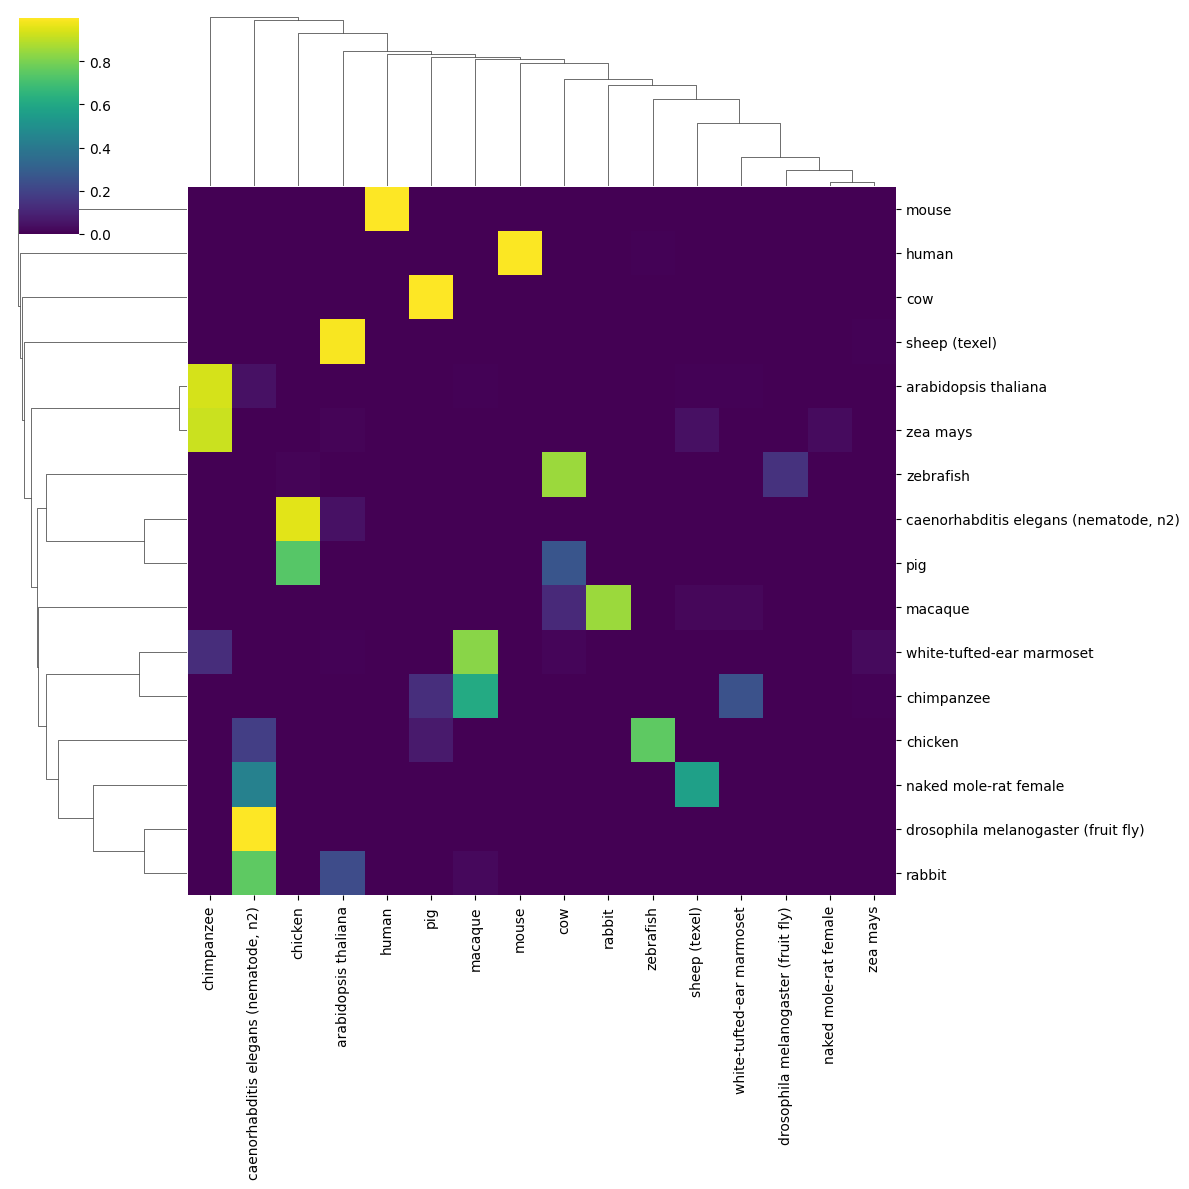

In [98]:
# Plot using clustermap
sns.clustermap(matrix_counts, cmap="viridis", figsize=(12, 12))
plt.show()

In [89]:
# Create a contingency table (matrix) where rows are unique values from col -8
# and columns are unique values from col -7, with values being the counts.
matrix_counts = pd.crosstab(cl[:, -8], cl[:, -7])
matrix_counts

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
row_0,,,,,,,,,,,,,,,,,,,,,
1,322,0,0,0,1284,0,974,918,9138,132,0,10,99875,4156,0,19368,0,292,9,0,3
4,0,2061,0,0,0,0,0,0,1442,1,0,2,134588,978,0,17599,2678,13,2540,0,11351
5,0,2,0,0,0,0,6528,2773,0,0,0,0,10651,0,4,2,0,0,0,0,293
6,0,2878,0,0,0,3082,0,9296,618,0,0,0,22760,0,0,903,0,0,0,0,187
7,0,820,0,0,0,821,1054,0,0,0,0,0,5277,0,1922,60,0,0,10,1006,43491
8,0,5513,0,0,536,0,218264,0,0,96213,0,10416,128727,1486,0,5617,0,0,2005,0,93422
9,0,117,0,0,3,0,0,0,3001,0,0,1038,2569,0,0,7424,0,0,6524,0,575
11,0,115,0,0,0,0,0,0,80,6966,0,0,1323,0,0,547,0,0,0,0,0
12,0,200624,11,15118,896195,3406,6847,257655,5172608,8851,42338,23039,0,5631,10294,7076743,3822,3368,1330744,0,2825661


In [ ]:
matrix_counts = (matrix_counts.T / (1 + matrix_counts.sum(axis=1)).values).T

In [ ]:
res = translate(
    set(decoders["self_reported_ethnicity_ontology_term_id"].values()),
    "self_reported_ethnicity_ontology_term_id",
)

In [91]:
matrix_counts.index = [
    res[decoders["self_reported_ethnicity_ontology_term_id"][str(i)]]
    for i in matrix_counts.index
]
matrix_counts.columns = [
    res[decoders["self_reported_ethnicity_ontology_term_id"][str(i)]]
    for i in matrix_counts.columns
]

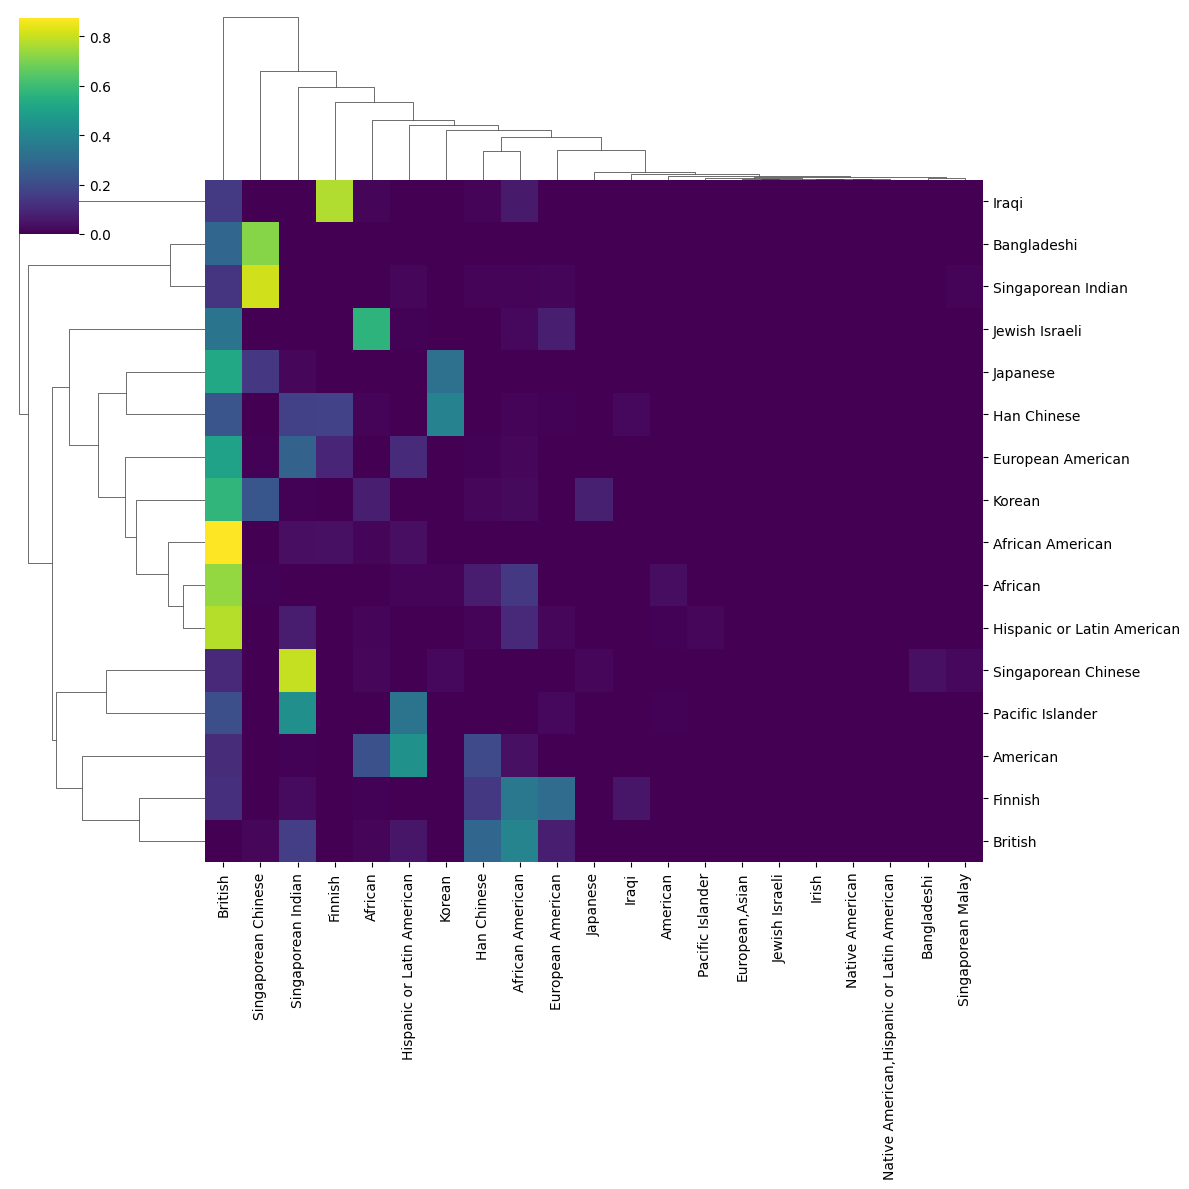

In [92]:
# Plot using clustermap
sns.clustermap(matrix_counts, cmap="viridis", figsize=(12, 12))
plt.show()

In [23]:
max_cells = 100_000
results = {}
# Get unique groups, excluding NaNs

for group in np.unique(cl[:, -8]):
    # Get indices for the group
    indices = np.argwhere(cl[:, -8] == group).flatten()
    total_cells = len(indices)

    # Randomly sample if count exceeds max_cells
    if len(indices) > max_cells:
        indices = np.random.choice(indices, max_cells, replace=False)

    # Calculate mean of the embedding
    results[
        res[decoders["self_reported_ethnicity_ontology_term_id"][str(group)]]
        + "_"
        + str(total_cells)
    ] = np.mean(scores[indices, 1], axis=0)
results

{'African_136481': -0.09644,
 'Hispanic or Latin American_173253': -0.0869,
 'Japanese_20253': -0.0943,
 'Korean_39724': -0.0984,
 'Singaporean Chinese_54461': -0.0949,
 'Han Chinese_562199': -0.0909,
 'Finnish_21251': -0.07715,
 'Iraqi_9031': -0.10754,
 'British_17882955': -0.09143,
 'American_6383': -0.1016,
 'Bangladeshi_5475': -0.0806,
 'African American_677988': -0.0913,
 'Pacific Islander_3124': -0.03812,
 'Jewish Israeli_944': -0.09766,
 'European American_225360': -0.085,
 'Singaporean Indian_989438': -0.0893}

In [44]:
results

{'African_136481': -0.09564,
 'Hispanic or Latin American_173253': -0.0858,
 'Japanese_20253': -0.0943,
 'Korean_39724': -0.0984,
 'Singaporean Chinese_54461': -0.0949,
 'Han Chinese_562199': -0.10565,
 'Finnish_21251': -0.07715,
 'Iraqi_9031': -0.10754,
 'British_17882955': -0.097,
 'American_6383': -0.1016,
 'Bangladeshi_5475': -0.0806,
 'African American_677988': -0.0895,
 'Pacific Islander_3124': -0.03812,
 'Jewish Israeli_944': -0.09766,
 'European American_225360': -0.0817,
 'Singaporean Indian_989438': -0.09705}

In [28]:
max_cells = 1_000
results = {}
# Get unique groups, excluding NaNs

for group in np.unique(cl[:, -8]):
    # Get indices for the group
    indices = np.argwhere(cl[:, -8] == group).flatten()
    total_cells = len(indices)

    # Randomly sample if count exceeds max_cells
    if len(indices) > max_cells:
        indices = np.random.choice(indices, max_cells, replace=False)
    print(len(indices))

    # Calculate mean of the embedding
    results[
        res[decoders["self_reported_ethnicity_ontology_term_id"][str(group)]]
        + "_"
        + str(total_cells)
    ] = np.mean(embs[indices, -20:-12], axis=0)
df_avg = pd.DataFrame(results).T
df_avg

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
944
1000
1000


,0,1,2,3,4,5,6,7
African_136481,0.017975,-0.009941,-0.010368,0.021622,0.023651,0.026764,0.007164,0.025925
Hispanic or Latin American_173253,0.017166,-0.010803,-0.009178,0.022583,0.023560,0.027374,0.006729,0.025787
Japanese_20253,0.018295,-0.009987,-0.011559,0.023468,0.023712,0.027740,0.007874,0.027740
Korean_39724,0.019348,-0.007671,-0.011246,0.018967,0.024475,0.026825,0.006802,0.026733
Singaporean Chinese_54461,0.016403,-0.009277,-0.008545,0.021469,0.025009,0.026062,0.007473,0.027039
Han Chinese_562199,0.016769,-0.010643,-0.010139,0.024246,0.022308,0.027939,0.009392,0.025345
Finnish_21251,0.019241,-0.009216,-0.012054,0.021469,0.023361,0.027481,0.008514,0.026093
Iraqi_9031,0.016953,-0.009171,-0.009026,0.020584,0.022705,0.026642,0.006481,0.026062
British_17882955,0.018112,-0.009377,-0.011276,0.023285,0.026794,0.026825,0.009422,0.026840
American_6383,0.015587,-0.009041,-0.008583,0.021667,0.021805,0.026413,0.007366,0.025803


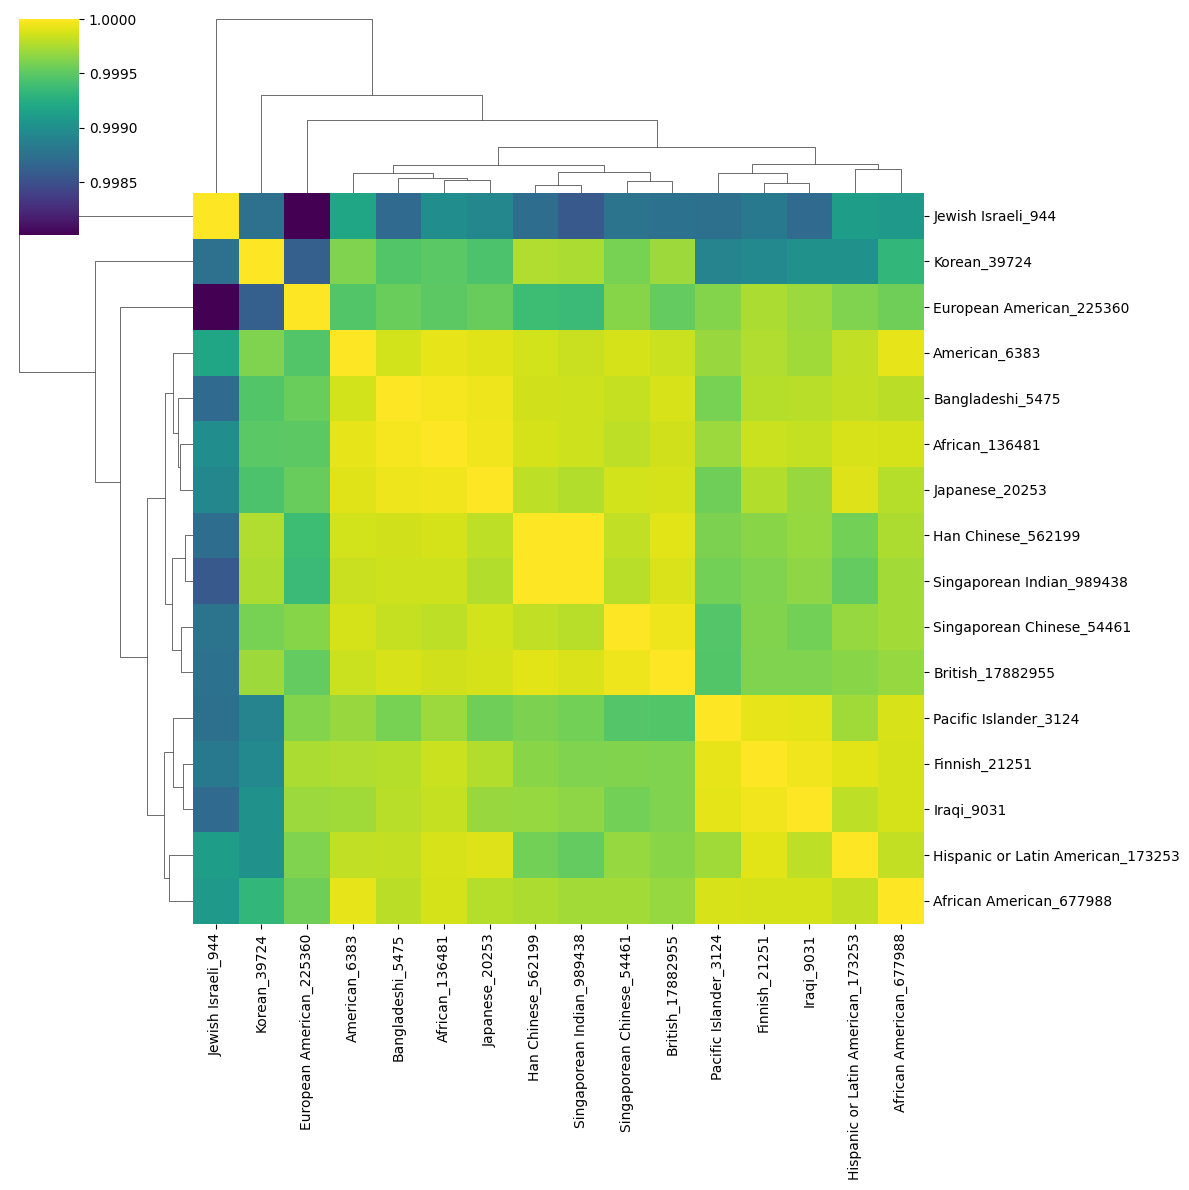

In [ ]:
# Compute cosine similarity
similarity_matrix = cosine_similarity(df_avg)
similarity_df = pd.DataFrame(
    similarity_matrix, index=df_avg.index, columns=df_avg.index
)

# Plot using clustermap
sns.clustermap(similarity_df, cmap="viridis", figsize=(12, 12))
plt.show()

In [ ]:
res = translate(
    set(decoders["organism_ontology_term_id"].values()),
    "organism_ontology_term_id",
)

In [19]:
max_cells = 7_000
results = {}
# Get unique groups, excluding NaNs

for group in np.unique(cl[:, -4]):
    # Get indices for the group
    indices = np.argwhere(cl[:, -4] == group).flatten()

    # Randomly sample if count exceeds max_cells
    if len(indices) > max_cells:
        indices = np.random.choice(indices, max_cells, replace=False)
    print(len(indices))

    # Calculate mean of the embedding
    results[res[decoders["organism_ontology_term_id"][str(group)]]] = np.mean(
        embs[indices, -10:-2], axis=0
    )
df_avg = pd.DataFrame(results).T
df_avg

7000
7000
7000
7000
7000
7000
7000
7000
7000
7000
7000
7000
7000
7000
7000
7000


,0,1,2,3,4,5,6,7
mouse,0.006744,-0.005836,0.000733,0.003380,-0.001099,-0.003038,-0.002090,-0.005363
naked mole-rat female,0.007042,-0.006317,0.000430,0.002615,-0.001150,-0.003016,-0.002068,-0.005386
arabidopsis thaliana,0.007122,-0.005268,0.000504,0.003126,-0.000673,-0.002979,-0.001500,-0.004810
zea mays,0.006977,-0.005455,0.000882,0.003138,-0.001046,-0.002428,-0.001919,-0.003698
"caenorhabditis elegans (nematode, n2)",0.006821,-0.005760,0.001064,0.002987,-0.001174,-0.002741,-0.002222,-0.004623
drosophila melanogaster (fruit fly),0.007172,-0.005753,0.000798,0.002958,-0.000919,-0.002678,-0.001987,-0.004337
zebrafish,0.007145,-0.005886,0.001263,0.002983,-0.000961,-0.003023,-0.002493,-0.005131
chicken,0.006927,-0.005638,0.001314,0.003378,-0.001052,-0.002865,-0.002405,-0.004677
white-tufted-ear marmoset,0.006981,-0.005547,0.001085,0.003159,-0.001069,-0.002884,-0.002197,-0.004742
macaque,0.007080,-0.005665,0.001160,0.002840,-0.000934,-0.002808,-0.002224,-0.004677


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


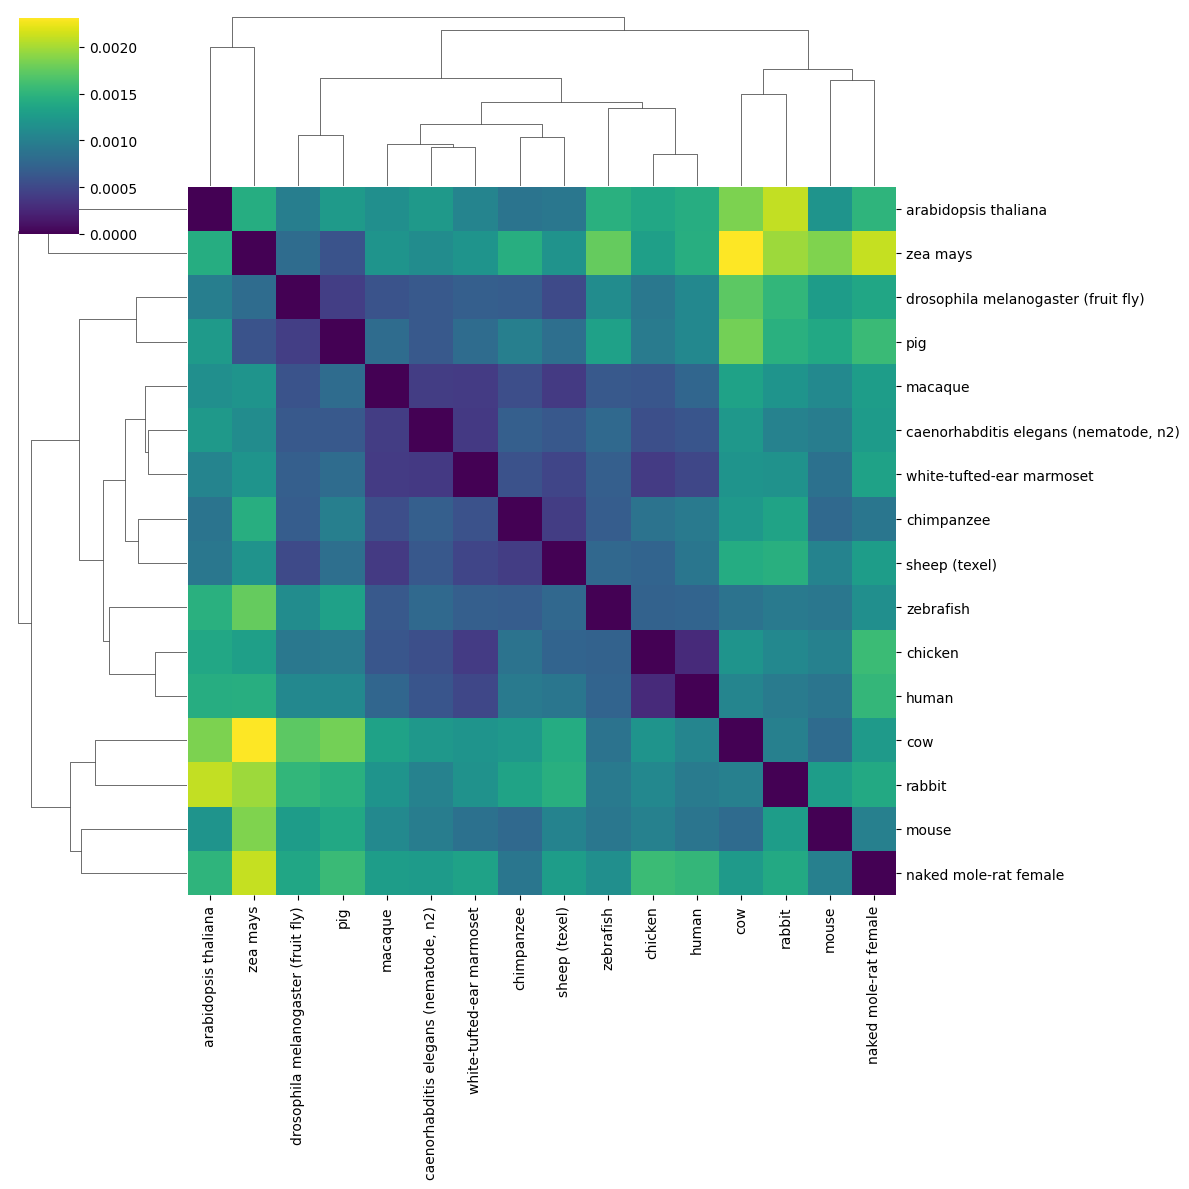

In [20]:
# Compute cosine similarity
X = df_avg.values.astype(np.float64)
similarity_matrix = np.sqrt(((X[:, None, :] - X[None, :, :]) ** 2).sum(axis=2))
similarity_df = pd.DataFrame(
    similarity_matrix, index=df_avg.index, columns=df_avg.index
)

# Plot using clustermap
sns.clustermap(similarity_df, cmap="viridis", figsize=(12, 12))
plt.show()

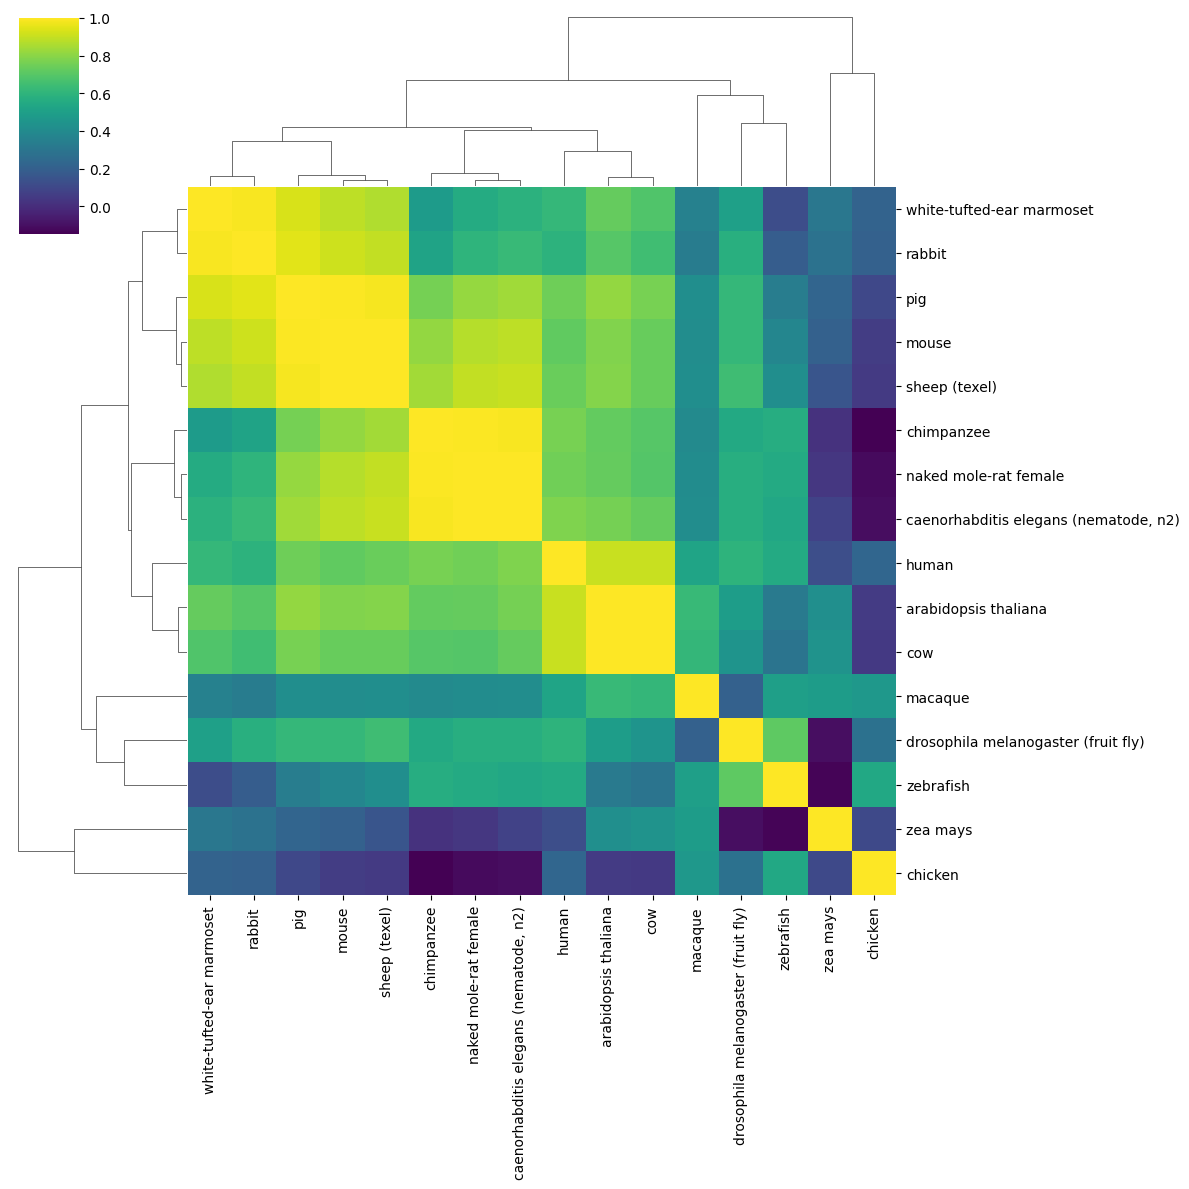

In [28]:
# Compute cosine similarity
similarity_matrix = cosine_similarity(df_avg)
similarity_df = pd.DataFrame(
    similarity_matrix, index=df_avg.index, columns=df_avg.index
)

# Plot using clustermap
sns.clustermap(similarity_df, cmap="viridis", figsize=(12, 12))
plt.show()

In [112]:
res = translate(
    set(decoders["organism_ontology_term_id"].values()),
    "organism_ontology_term_id",
)

In [ ]:
max_cells = 100_000
results = {}
# Get unique groups, excluding NaNs

for group in np.unique(cl[:, -8]):
    # Get indices for the group
    indices = np.argwhere(cl[:, -8] == group).flatten()
    tot_ind = len(indices)

    # Randomly sample if count exceeds max_cells
    if len(indices) > max_cells:
        indices = np.random.choice(indices, max_cells, replace=False)

    # Calculate mean of the embedding
    results[
        res[decoders["self_reported_ethnicity_ontology_term_id"][str(group)]]
        + "_"
        + str(tot_ind)
    ] = np.mean(scores[indices, 0], axis=0)

In [ ]:
dict(sorted(results.items(), key=lambda item: item[1]))

In [116]:
dict(sorted(results.items(), key=lambda item: item[1]))

{'caenorhabditis elegans (nematode, n2)_15194': 0.903,
 'naked mole-rat female_26286': 0.904,
 'macaque_189021': 0.9077,
 'chicken_36235': 0.9116,
 'zea mays_20007': 0.918,
 'rabbit_25040': 0.9194,
 'cow_23516': 0.92,
 'chimpanzee_17635': 0.922,
 'pig_97918': 0.923,
 'zebrafish_187041': 0.9233,
 'arabidopsis thaliana_93515': 0.9263,
 'drosophila melanogaster (fruit fly)_93391': 0.9297,
 'human_13814000': 0.93,
 'mouse_6151749': 0.935,
 'sheep (texel)_10681': 0.9375,
 'white-tufted-ear marmoset_7091': 0.941}

In [ ]:
# cell_labels = cl[:, 0:3]
# cell_emb = embs[:, 256 : 256 + 64]

In [5]:
pumap = PUMAP(
    n_neighbors=10,
    min_dist=0.1,
    metric="euclidean",
    n_components=2,
    beta=1.0,  # How much to weigh reconstruction loss for decoder
    # reconstruction_loss=F.binary_cross_entropy_with_logits, # pass in custom reconstruction loss functions
    random_state=None,
    lr=1e-3,
    epochs=10,
    batch_size=64,
    num_workers=1,
    num_gpus=1,
    match_nonparametric_umap=False,  # Train network to match embeddings from non parametric umap
)

pumap.fit(embs[:2_000_000, 256 : 256 + 64])

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Sat Nov 22 17:26:58 2025 Building RP forest with 76 trees
Sat Nov 22 17:27:47 2025 NN descent for 21 iterations
	 1  /  21
	 2  /  21
	 3  /  21
	Stopping threshold met -- exiting after 3 iterations


: 

: 

: 

In [ ]:
embedding = pumap.transform(torch.Tensor(embs[:, 256 : 256 + 64]))  # (50000, 2)

Reducing array of shape torch.Size([20040, 64]) to (20040, 2)


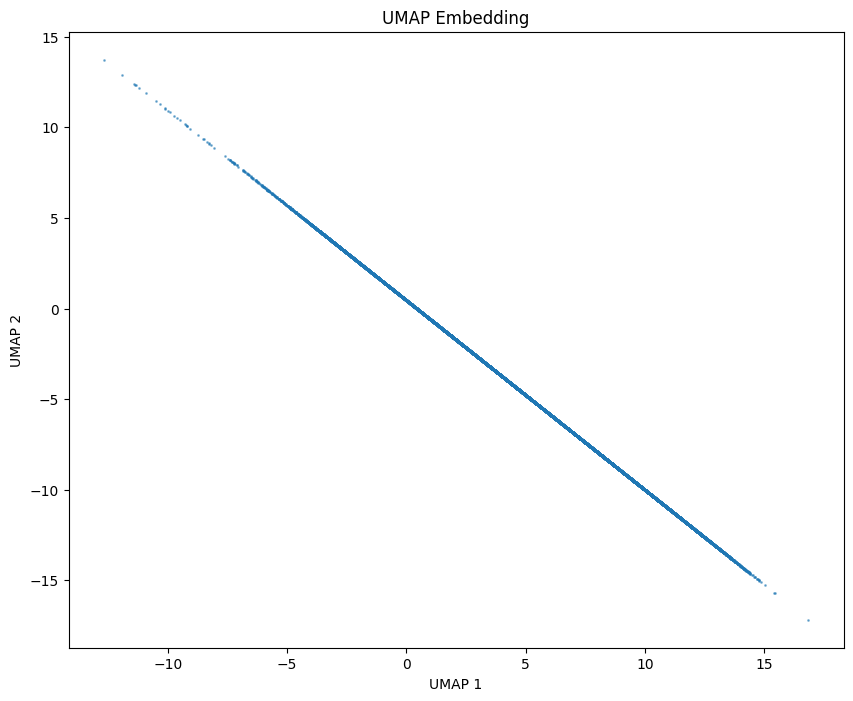

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, alpha=0.5)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP Embedding")
plt.show()

In [ ]:
path = "./umap_embeder.pkl"
pumap.save(path)

Pickled PUMAP object at ./umap_embeder.pkl


In [17]:
# Loading
pumap = load_pumap(path)

Loading PUMAP object from pickled file.
